In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import itertools
import os
import warnings
warnings.filterwarnings('ignore')
import copy
import ast

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import decomposition
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, RegressorMixin

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset
from torch.utils.tensorboard import SummaryWriter

from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig


In [114]:
# test different datasets
datasets = []


## Data Acquisition
##### Flat Acquisition using csv files

In [115]:
movies = pd.read_csv('./data/movies.csv')
ratings = pd.read_csv('./data/ratings.csv')
tags = pd.read_csv('./data/tags.csv')
genome_scores = pd.read_csv('./data/genome-scores.csv')
genome_tags = pd.read_csv('./data/genome-tags.csv')


In [116]:
# print the first 5 rows of the csv files
print('Movies:')
display(movies.head())
print('Ratings:')
display(ratings.head())
print('Tags:')
display(tags.head())
print('Genome Scores:')
display(genome_scores.head())
print('Genome Tags:')
display(genome_tags.head())


Movies:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Ratings:


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Tags:


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


Genome Scores:


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


Genome Tags:


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


### Data Wrangling

In [117]:
# ratings group by movieId with mean and count
grouped_ratings = ratings.groupby('movieId').agg({'rating': ['mean', 'count'], 'timestamp': ['mean']})
grouped_ratings.columns = ['mean_rating', 'rating_count', 'mean_timestamp']
grouped_ratings = grouped_ratings.astype({'mean_timestamp': 'int'})

# Dataset merge with movies and ratings, with missing rating films removed
df = pd.merge(movies, grouped_ratings, on='movieId')

display(df.head())


,movieId,title,genres,mean_rating,rating_count,mean_timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013


In [118]:
datasets.append({'transform': 'None', 'threshold': 'None', 'year': False, 'tags': True, 'genres': True, 'data': df})

In [119]:
# Group by tagId and compute mean relevance
mean_relevance = genome_scores.groupby('tagId').mean()['relevance']

# Filter out tags with low mean relevance
# TODO - test with different thresholds like 0.0, 0.2
for threshold in [0.0, 0.2]:
    good_tags = mean_relevance.where(mean_relevance > threshold).dropna().index
    genome_scores_2 = genome_scores[genome_scores['tagId'].isin(good_tags)]

    # Merge movies with genome scores
    genome_scores_2['tag'] = genome_scores_2['tagId'].map(genome_tags.set_index('tagId')['tag'].to_dict())
    genome_table = genome_scores_2.pivot_table(index='movieId', columns='tag', values='relevance')

    # Merge movies with genome table
    df_test = pd.merge(df, genome_table, on='movieId')
    print('Threshold: {}'.format(threshold))
    display(df_test.head())

    datasets.append({'transform': 'None', 'threshold': threshold, 'year': False, 'tags': True, 'genres': True, 'data': df_test})

datasets = datasets[1:]

Threshold: 0.0


,movieId,title,genres,mean_rating,rating_count,mean_timestamp,007,007 (series),18th century,1920s,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210,0.02875,0.02375,0.06250,0.07575,...,0.04050,0.01425,0.03050,0.03500,0.14125,0.05775,0.03900,0.02975,0.08475,0.02200
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117,0.04125,0.04050,0.06275,0.08275,...,0.05250,0.01575,0.01250,0.02000,0.12225,0.03275,0.02100,0.01100,0.10525,0.01975
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256,0.04675,0.05550,0.02925,0.08700,...,0.06275,0.01950,0.02225,0.02300,0.12200,0.03475,0.01700,0.01800,0.09100,0.01775
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471,0.03425,0.03800,0.04050,0.03100,...,0.05325,0.02800,0.01675,0.03875,0.18200,0.07050,0.01625,0.01425,0.08850,0.01500
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013,0.04300,0.05325,0.03800,0.04100,...,0.05350,0.02050,0.01425,0.02550,0.19225,0.02675,0.01625,0.01300,0.08700,0.01600


Threshold: 0.2


,movieId,title,genres,mean_rating,rating_count,mean_timestamp,absurd,action,adaptation,adapted from:book,...,visceral,visual,visually appealing,visually stunning,weapons,weird,whimsical,witty,women,writers
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210,0.10400,0.66250,0.31675,0.28600,...,0.15150,0.56375,0.3150,0.67325,0.26375,0.42700,0.58700,0.69400,0.08925,0.14125
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117,0.15925,0.64025,0.51450,0.48450,...,0.07325,0.38150,0.2250,0.21700,0.17800,0.38650,0.29250,0.18725,0.13525,0.12225
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256,0.11375,0.16025,0.25200,0.19375,...,0.10175,0.10725,0.1960,0.09850,0.14125,0.24350,0.13025,0.22325,0.35075,0.12200
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471,0.13375,0.14700,0.50700,0.46175,...,0.08800,0.10750,0.2115,0.11625,0.28950,0.21975,0.14775,0.10725,0.97525,0.18200
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013,0.15475,0.15575,0.28925,0.19800,...,0.08275,0.11925,0.1850,0.11875,0.12025,0.29350,0.16425,0.10475,0.40225,0.19225


### Data Preparation (Data cleaning, Duplicates filtering, Data encoding)

##### Data Cleaning

In [120]:
for i, dataset in enumerate(datasets):
    df = dataset['data']

    print('\nFillna for dataset {}'.format(i+1))
    # print number of rows
    print('Number of rows: ', df.shape[0])

    # fill rows with missing values (there are films with no tags, so we fill these tag columns set to 0)
    df = df.fillna(0)

    # print number of rows after dropping missing values
    print('Number of rows after dropping missing values: ', df.shape[0])


    dataset['data'] = df



Fillna for dataset 1
Number of rows:  13816
Number of rows after dropping missing values:  13816

Fillna for dataset 2
Number of rows:  13816
Number of rows after dropping missing values:  13816


##### Data Encoding
Multicategorical One-Hot encoding for film genres

In [121]:
for dataset in datasets:

    df = dataset['data']


    # one hot encoding for genres
    categories = set()
    for s in df['genres'].str.split('|').values:
        if s != ['(no genres listed)']:
            categories = categories.union(set(s))

    print(categories)

    # add columns for each category
    for category in categories:
        df[category] = df['genres'].str.contains(category).astype(int)

    # delete genres column
    df = df.drop(columns=['genres'])

    display(df.head())
    

    dataset['data'] = df

{'IMAX', 'Documentary', 'Children', 'Fantasy', 'Musical', 'Drama', 'Western', 'Crime', 'Horror', 'Action', 'Animation', 'Sci-Fi', 'Thriller', 'Comedy', 'Film-Noir', 'Romance', 'Adventure', 'Mystery', 'War'}


,movieId,title,mean_rating,rating_count,mean_timestamp,007,007 (series),18th century,1920s,1930s,...,Action,Animation,Sci-Fi,Thriller,Comedy,Film-Noir,Romance,Adventure,Mystery,War
0,1,Toy Story (1995),3.893708,57309,1153152210,0.02875,0.02375,0.06250,0.07575,0.14075,...,0,1,0,0,1,0,0,1,0,0
1,2,Jumanji (1995),3.251527,24228,1122310117,0.04125,0.04050,0.06275,0.08275,0.09100,...,0,0,0,0,0,0,0,1,0,0
2,3,Grumpier Old Men (1995),3.142028,11804,980602256,0.04675,0.05550,0.02925,0.08700,0.04750,...,0,0,0,0,1,0,1,0,0,0
3,4,Waiting to Exhale (1995),2.853547,2523,942460471,0.03425,0.03800,0.04050,0.03100,0.06500,...,0,0,0,0,1,0,1,0,0,0
4,5,Father of the Bride Part II (1995),3.058434,11714,1004723013,0.04300,0.05325,0.03800,0.04100,0.05400,...,0,0,0,0,1,0,0,0,0,0


{'IMAX', 'Documentary', 'Children', 'Fantasy', 'Musical', 'Drama', 'Western', 'Crime', 'Horror', 'Action', 'Animation', 'Sci-Fi', 'Thriller', 'Comedy', 'Film-Noir', 'Romance', 'Adventure', 'Mystery', 'War'}


,movieId,title,mean_rating,rating_count,mean_timestamp,absurd,action,adaptation,adapted from:book,adventure,...,Action,Animation,Sci-Fi,Thriller,Comedy,Film-Noir,Romance,Adventure,Mystery,War
0,1,Toy Story (1995),3.893708,57309,1153152210,0.10400,0.66250,0.31675,0.28600,0.89375,...,0,1,0,0,1,0,0,1,0,0
1,2,Jumanji (1995),3.251527,24228,1122310117,0.15925,0.64025,0.51450,0.48450,0.97600,...,0,0,0,0,0,0,0,1,0,0
2,3,Grumpier Old Men (1995),3.142028,11804,980602256,0.11375,0.16025,0.25200,0.19375,0.32150,...,0,0,0,0,1,0,1,0,0,0
3,4,Waiting to Exhale (1995),2.853547,2523,942460471,0.13375,0.14700,0.50700,0.46175,0.14875,...,0,0,0,0,1,0,1,0,0,0
4,5,Father of the Bride Part II (1995),3.058434,11714,1004723013,0.15475,0.15575,0.28925,0.19800,0.16350,...,0,0,0,0,1,0,0,0,0,0


##### Duplicates Filtering
The following results show that there are no duplicates in the dataset (as expected after merge operation).

In [122]:
for i, dataset in enumerate(datasets):
    
    df = dataset['data']

    print('\nData filtering for dataset {}'.format(i+1))
    # print number of rows
    print('Number of rows: ', df.shape[0])

    # drop duplicated rows
    df = df.drop_duplicates()

    # print number of rows after dropping missing values
    print('Number of rows after dropping duplicated rows: ', df.shape[0])


    dataset['data'] = df



Data filtering for dataset 1
Number of rows:  13816
Number of rows after dropping duplicated rows:  13816

Data filtering for dataset 2
Number of rows:  13816
Number of rows after dropping duplicated rows:  13816


## Data Visualization

In [123]:
""" # rating distribution from ratings.csv
sns.countplot(x='rating', data=ratings)
plt.show()

sns.boxplot(x='rating', data=ratings)
plt.show() """


" # rating distribution from ratings.csv\nsns.countplot(x='rating', data=ratings)\nplt.show()\n\nsns.boxplot(x='rating', data=ratings)\nplt.show() "

Rather than using discrete bins, a KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate. This is used for continuous attributes like rating mean.

It is done to show differences after data aggregation in calculating mean for each film.

In [124]:
""" df = datasets[0]['data']

# rating distribution from df
sns.kdeplot(df['mean_rating'])
plt.xlabel('rating mean for film')
plt.title('Rating distribution in dataframe')
plt.show() """


" df = datasets[0]['data']\n\n# rating distribution from df\nsns.kdeplot(df['mean_rating'])\nplt.xlabel('rating mean for film')\nplt.title('Rating distribution in dataframe')\nplt.show() "

In [125]:
""" movies_to_show = 5
fig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))

most_rated_movies = ratings.groupby('movieId').count().sort_values('rating', ascending=False).head(movies_to_show).index

to_line_plot = []
for i in range(movies_to_show):
    tmp = ratings.where(ratings['movieId'] == most_rated_movies[i]).dropna()
    tmp['date'] = pd.to_datetime(tmp['timestamp'], unit='s')
    
    # Computing the mean for each month
    tmp = tmp.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    to_line_plot.append(tmp)
    movie_title = movies.where(movies['movieId'] == most_rated_movies[i]).dropna()['title'].values[0]
    axs[i].set_title("Movie: '" + movie_title + "'")
    

for i in range(movies_to_show):
    sns.lineplot(x='date', y='rating', ax=axs[i], data=to_line_plot[i])

fig.suptitle('Rating evolution for the 5 most rated movies')
plt.show() """

' movies_to_show = 5\nfig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))\n\nmost_rated_movies = ratings.groupby(\'movieId\').count().sort_values(\'rating\', ascending=False).head(movies_to_show).index\n\nto_line_plot = []\nfor i in range(movies_to_show):\n    tmp = ratings.where(ratings[\'movieId\'] == most_rated_movies[i]).dropna()\n    tmp[\'date\'] = pd.to_datetime(tmp[\'timestamp\'], unit=\'s\')\n    \n    # Computing the mean for each month\n    tmp = tmp.resample("M", on=\'date\').mean()[[\'movieId\', \'rating\']].dropna()\n    to_line_plot.append(tmp)\n    movie_title = movies.where(movies[\'movieId\'] == most_rated_movies[i]).dropna()[\'title\'].values[0]\n    axs[i].set_title("Movie: \'" + movie_title + "\'")\n    \n\nfor i in range(movies_to_show):\n    sns.lineplot(x=\'date\', y=\'rating\', ax=axs[i], data=to_line_plot[i])\n\nfig.suptitle(\'Rating evolution for the 5 most rated movies\')\nplt.show() '

In [126]:
""" # Same as above cell but the 3 movies with the highest standard deviation
movies_to_show = 3
fig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))

# Take movies with at least 1000 ratings
high_std_movies = ratings.where(
    ratings['movieId']
    .isin(ratings.groupby('movieId')
          .count()
          .where(ratings.groupby('movieId').count()['rating'] > 1000)
          .dropna().index)
    ).dropna()

# most_rated_movies = ratings.groupby('movieId').count().sort_values('rating', ascending=False).head(movies_to_show).index
high_std_movies = high_std_movies.groupby('movieId').std().sort_values('rating', ascending=False).head(movies_to_show).index

to_line_plot = []
for i in range(movies_to_show):
    tmp = ratings.where(ratings['movieId'] == high_std_movies[i]).dropna()
    tmp['date'] = pd.to_datetime(tmp['timestamp'], unit='s')
    
    # Computing the mean for each month
    tmp = tmp.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    to_line_plot.append(tmp)
    movie_title = movies.where(movies['movieId'] == high_std_movies[i]).dropna()['title'].values[0]
    axs[i].set_title("Movie: '" + movie_title + "'")

for i in range(movies_to_show):
    sns.lineplot(x='date', y='rating', ax=axs[i], data=to_line_plot[i])

# Print the titles of the movies
plt.show() """

' # Same as above cell but the 3 movies with the highest standard deviation\nmovies_to_show = 3\nfig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))\n\n# Take movies with at least 1000 ratings\nhigh_std_movies = ratings.where(\n    ratings[\'movieId\']\n    .isin(ratings.groupby(\'movieId\')\n          .count()\n          .where(ratings.groupby(\'movieId\').count()[\'rating\'] > 1000)\n          .dropna().index)\n    ).dropna()\n\n# most_rated_movies = ratings.groupby(\'movieId\').count().sort_values(\'rating\', ascending=False).head(movies_to_show).index\nhigh_std_movies = high_std_movies.groupby(\'movieId\').std().sort_values(\'rating\', ascending=False).head(movies_to_show).index\n\nto_line_plot = []\nfor i in range(movies_to_show):\n    tmp = ratings.where(ratings[\'movieId\'] == high_std_movies[i]).dropna()\n    tmp[\'date\'] = pd.to_datetime(tmp[\'timestamp\'], unit=\'s\')\n    \n    # Computing the mean for each month\n    tmp = tmp.resample("M", 

Plot density for every attribute of dataset

In [127]:
"""
df = datasets[0]['data']

# print distribution for ratings
fig, axs = plt.subplots(1, 2, figsize=(10, 2))
sns.kdeplot(df['mean_timestamp'], ax=axs[0], color='r', label='timestamp')
sns.kdeplot(df['rating_count'], ax=axs[1], color='b', label='rating')

axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].title.set_text('Timestamp mean distribution')
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].title.set_text('Rating count distribution')
plt.show() """


"\ndf = datasets[0]['data']\n\n# print distribution for ratings\nfig, axs = plt.subplots(1, 2, figsize=(10, 2))\nsns.kdeplot(df['mean_timestamp'], ax=axs[0], color='r', label='timestamp')\nsns.kdeplot(df['rating_count'], ax=axs[1], color='b', label='rating')\n\naxs[0].set_xlabel('')\naxs[0].set_ylabel('')\naxs[0].title.set_text('Timestamp mean distribution')\naxs[1].set_xlabel('')\naxs[1].set_ylabel('')\naxs[1].title.set_text('Rating count distribution')\nplt.show() "

In [128]:
"""
df = datasets[0]['data']

# density plot for rating_count
fig, axs = plt.subplots(1,2, figsize=(10, 5))
sns.kdeplot(df['rating_count'], ax=axs[0], label='rating_count')
sns.kdeplot(df['rating_count'].where(df['rating_count'] < 50), ax=axs[1], label='rating_count < 50')

print('Number of movies with rating_count < 50: ', df.where(df['rating_count'] < 50).count()[0])
print('Number of all movies: ', df.shape[0]) """

"\ndf = datasets[0]['data']\n\n# density plot for rating_count\nfig, axs = plt.subplots(1,2, figsize=(10, 5))\nsns.kdeplot(df['rating_count'], ax=axs[0], label='rating_count')\nsns.kdeplot(df['rating_count'].where(df['rating_count'] < 50), ax=axs[1], label='rating_count < 50')\n\nprint('Number of movies with rating_count < 50: ', df.where(df['rating_count'] < 50).count()[0])\nprint('Number of all movies: ', df.shape[0]) "

In [129]:
"""
df = datasets[0]['data']

# plot for categories
cat = list(categories)

# count the number of rows containing 1 for each category
cat_dict = {}
for category in cat:
    cat_dict[category] = df[category].sum()

# order the dictionary by value in descending order
cat_dict = {k: v for k, v in sorted(cat_dict.items(), key=lambda item: item[1], reverse=True)}

# plot an histogram of the number of rows for each category
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.barplot(x=list(cat_dict.keys()), y=list(cat_dict.values()))
ax.bar_label(container=ax.containers[0], labels=list(cat_dict.keys()))
ax.set_ylabel('Number of movies')
plt.xticks([])
plt.show() """


"\ndf = datasets[0]['data']\n\n# plot for categories\ncat = list(categories)\n\n# count the number of rows containing 1 for each category\ncat_dict = {}\nfor category in cat:\n    cat_dict[category] = df[category].sum()\n\n# order the dictionary by value in descending order\ncat_dict = {k: v for k, v in sorted(cat_dict.items(), key=lambda item: item[1], reverse=True)}\n\n# plot an histogram of the number of rows for each category\nfig, axs = plt.subplots(1, 1, figsize=(20, 10))\nax = sns.barplot(x=list(cat_dict.keys()), y=list(cat_dict.values()))\nax.bar_label(container=ax.containers[0], labels=list(cat_dict.keys()))\nax.set_ylabel('Number of movies')\nplt.xticks([])\nplt.show() "

In [130]:
"""
df = datasets[0]['data']

# plot for tags

tag_columns = list(df.columns)
tag_columns = df.drop(columns=['movieId','title','mean_rating','rating_count', 'mean_timestamp']).columns
tag_columns = [tag for tag in tag_columns if tag not in categories]

tag_dict = {}
for tag in tag_columns:
    tag_dict[tag] = df[tag].mean()

# order the dictionary by value in descending order and plot the first 10
tag_dict = {k: v for k, v in sorted(tag_dict.items(), key=lambda item: item[1], reverse=True)}

# display('Tag mean: ', tag_dict)

fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax1 = sns.barplot(x=list(tag_dict.keys())[:], y=list(tag_dict.values())[:] , ax=axs[0])
ax1.xaxis.set_ticks([])
ax1.set_title('All tags')
ax1.set_ylabel('Mean Value')
ax2 = sns.barplot(x=list(tag_dict.keys())[:10], y=list(tag_dict.values())[:10] , ax=axs[1])
ax2.bar_label(container=ax.containers[0], labels=list(tag_dict.keys())[:10])
ax2.set_title('Top 10 tags')
ax2.set_ylabel('Mean Value')
plt.xticks([])
plt.show() """


"\ndf = datasets[0]['data']\n\n# plot for tags\n\ntag_columns = list(df.columns)\ntag_columns = df.drop(columns=['movieId','title','mean_rating','rating_count', 'mean_timestamp']).columns\ntag_columns = [tag for tag in tag_columns if tag not in categories]\n\ntag_dict = {}\nfor tag in tag_columns:\n    tag_dict[tag] = df[tag].mean()\n\n# order the dictionary by value in descending order and plot the first 10\ntag_dict = {k: v for k, v in sorted(tag_dict.items(), key=lambda item: item[1], reverse=True)}\n\n# display('Tag mean: ', tag_dict)\n\nfig, axs = plt.subplots(2, 1, figsize=(20, 15))\nax1 = sns.barplot(x=list(tag_dict.keys())[:], y=list(tag_dict.values())[:] , ax=axs[0])\nax1.xaxis.set_ticks([])\nax1.set_title('All tags')\nax1.set_ylabel('Mean Value')\nax2 = sns.barplot(x=list(tag_dict.keys())[:10], y=list(tag_dict.values())[:10] , ax=axs[1])\nax2.bar_label(container=ax.containers[0], labels=list(tag_dict.keys())[:10])\nax2.set_title('Top 10 tags')\nax2.set_ylabel('Mean Value')\np

In [131]:
"""
df = datasets[0]['data']

# count the number of rows containing 1 for Film-Noir and IMAX
print('Number of Film-Noir movies: ', df['Film-Noir'].sum())
print('Number of IMAX movies: ', df['IMAX'].sum()) """


"\ndf = datasets[0]['data']\n\n# count the number of rows containing 1 for Film-Noir and IMAX\nprint('Number of Film-Noir movies: ', df['Film-Noir'].sum())\nprint('Number of IMAX movies: ', df['IMAX'].sum()) "

## Data Preprocessing

In [132]:
n = len(datasets)
for i in range(n):

    dataset = datasets[i]
    df = dataset['data']

    df_title = df['title']

    # delete title and movieId columns
    df = df.drop(columns=['movieId', 'title'])
    #dataset['data'] = df

    # from title extract year
    df['year'] = df_title.str.extract('(\(\d{4}\))', expand=True)
    # remove parentheses
    df['year'] = df['year'].str.extract('(\d{4})', expand=True)

    # remove movies with no year
    df = df.dropna(subset=['year'])

    # convert year to int
    df['year'] = df['year'].astype(int)

    #display(df.head())
    
    datasets.append({'transform': dataset['transform'], 'threshold': dataset['threshold'], 'year': True, 'tags': dataset['tags'], 'genres': dataset['genres'], 'data': df})
    

In [133]:
"""
df = datasets[0]['data']

# density plot for film year
sns.kdeplot(df['year'])
plt.show() """

"\ndf = datasets[0]['data']\n\n# density plot for film year\nsns.kdeplot(df['year'])\nplt.show() "

In [134]:
"""
df = datasets[0]['data']

# Compute the number of unique values for each column
unique_values = {}
for column in df.columns:
    if column == 'mean_rating' or column == 'mean_timestamp' or column == 'year':
        unique_values[column] = np.unique(df[column], return_counts=True)

# Print the number of unique values for each column
for column in unique_values:
    print(column, ':', unique_values[column])

# Plot the number of unique values for each column
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 10))
sns.lineplot(x=unique_values['mean_rating'][0], y=unique_values['mean_rating'][1], ax=axs[0])
axs[0].set_xlabel('mean rating')
axs[0].set_ylabel('number of unique values')
sns.lineplot(x=unique_values['mean_timestamp'][0], y=unique_values['mean_timestamp'][1], ax=axs[1])
axs[1].set_xlabel('mean timestamp')
axs[1].set_ylabel('number of unique values')
sns.lineplot(x=unique_values['year'][0], y=unique_values['year'][1], ax=axs[2])
axs[2].set_xlabel('year')
axs[2].set_ylabel('number of unique values')
plt.show() """


"\ndf = datasets[0]['data']\n\n# Compute the number of unique values for each column\nunique_values = {}\nfor column in df.columns:\n    if column == 'mean_rating' or column == 'mean_timestamp' or column == 'year':\n        unique_values[column] = np.unique(df[column], return_counts=True)\n\n# Print the number of unique values for each column\nfor column in unique_values:\n    print(column, ':', unique_values[column])\n\n# Plot the number of unique values for each column\nfig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 10))\nsns.lineplot(x=unique_values['mean_rating'][0], y=unique_values['mean_rating'][1], ax=axs[0])\naxs[0].set_xlabel('mean rating')\naxs[0].set_ylabel('number of unique values')\nsns.lineplot(x=unique_values['mean_timestamp'][0], y=unique_values['mean_timestamp'][1], ax=axs[1])\naxs[1].set_xlabel('mean timestamp')\naxs[1].set_ylabel('number of unique values')\nsns.lineplot(x=unique_values['year'][0], y=unique_values['year'][1], ax=axs[2])\naxs[2].set_xlabel('year

In [135]:
"""
df = datasets[0]['data']

# show year and year_timestamp in the same plot with values from 2000 to 2020
df_year = df.copy()
df_year['mean_timestamp'] = pd.to_datetime(df['mean_timestamp'], unit='s')
df_year['year_timestamp'] = df_year['mean_timestamp'].dt.year

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.kdeplot(df_year['year_timestamp'], ax=axs[0], label='timestamp year')
sns.kdeplot(df_year['year'], ax=axs[0], label='film year')
axs[0].set_xlabel('year')
sns.kdeplot(df_year['year_timestamp'], ax=axs[1], label='timestamp year')
sns.kdeplot(df_year['year'], ax=axs[1], label='film year')
axs[1].set_xlabel('year')
axs[1].set_xlim(2000, 2020)
axs[1].set_xticks(np.arange(2000, 2022, 4))
plt.show() """


"\ndf = datasets[0]['data']\n\n# show year and year_timestamp in the same plot with values from 2000 to 2020\ndf_year = df.copy()\ndf_year['mean_timestamp'] = pd.to_datetime(df['mean_timestamp'], unit='s')\ndf_year['year_timestamp'] = df_year['mean_timestamp'].dt.year\n\nfig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))\nsns.kdeplot(df_year['year_timestamp'], ax=axs[0], label='timestamp year')\nsns.kdeplot(df_year['year'], ax=axs[0], label='film year')\naxs[0].set_xlabel('year')\nsns.kdeplot(df_year['year_timestamp'], ax=axs[1], label='timestamp year')\nsns.kdeplot(df_year['year'], ax=axs[1], label='film year')\naxs[1].set_xlabel('year')\naxs[1].set_xlim(2000, 2020)\naxs[1].set_xticks(np.arange(2000, 2022, 4))\nplt.show() "

In [136]:
n = len(datasets)
for i in range(n):

    dataset = datasets[i]
    df = dataset['data']

    # TAGS AND GENRES: No drop
    
    # ONLY TAGS: Drop columns that are in cat but not in lower_case_tags
    lower_case_tags = [str.lower(t) for t in genome_tags['tag'].values]
    cat = list(categories)
    for c in cat:
        if c.lower() in lower_case_tags and c in df.columns:
            df = df.drop(columns=[c])
            # print('Dropped column', c)
    #display(df.head())
    datasets.append({'transform': dataset['transform'], 'threshold': dataset['threshold'], 'year': dataset['year'], 'tags': True, 'genres': False, 'data': df})


    df = dataset['data']

    # ONLY GENRES: Drop columns that are in lower_case_tags but not in cat
    lower_case_tags = [str.lower(t) for t in genome_tags['tag'].values]
    cat = list(categories)
    for c in lower_case_tags:
        if c not in cat and c in df.columns:
            df = df.drop(columns=[c])
            # print('Dropped column', c)
    #display(df.head())
    datasets.append({'transform': dataset['transform'], 'threshold': dataset['threshold'], 'year': dataset['year'], 'tags': False, 'genres': True, 'data': df})



In [137]:
""" # TODO - balancing dataset only for training set
# remove samples_to_drop movies with mean_rating between 2.5 and 4
samples_to_drop = 25000
df_preprocessed = df.copy()
df_preprocessed = df_preprocessed.drop(df_preprocessed[(df_preprocessed['mean_rating'] >= 2.5) & (df_preprocessed['mean_rating'] <= 4)].sample(samples_to_drop).index)

# rating distribution from df
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(df['mean_rating'], ax=axs[0])
sns.kdeplot(df_preprocessed['mean_rating'], ax=axs[1])
plt.xlabel('rating mean for film')
plt.title('Rating distribution in dataframe')
plt.show()

# number of samples in df and df_preprocessed
print('Number of samples in df: ', df.shape[0])
print('Number of samples in df_preprocessed: ', df_preprocessed.shape[0]) """


" # TODO - balancing dataset only for training set\n# remove samples_to_drop movies with mean_rating between 2.5 and 4\nsamples_to_drop = 25000\ndf_preprocessed = df.copy()\ndf_preprocessed = df_preprocessed.drop(df_preprocessed[(df_preprocessed['mean_rating'] >= 2.5) & (df_preprocessed['mean_rating'] <= 4)].sample(samples_to_drop).index)\n\n# rating distribution from df\nfig, axs = plt.subplots(1, 2, figsize=(10, 5))\nsns.kdeplot(df['mean_rating'], ax=axs[0])\nsns.kdeplot(df_preprocessed['mean_rating'], ax=axs[1])\nplt.xlabel('rating mean for film')\nplt.title('Rating distribution in dataframe')\nplt.show()\n\n# number of samples in df and df_preprocessed\nprint('Number of samples in df: ', df.shape[0])\nprint('Number of samples in df_preprocessed: ', df_preprocessed.shape[0]) "

### Normalization

In [138]:
# TODO - fit the model to raw, scaled and standardized data and compare the performance for best results
n = len(datasets)
for i in range(n):
    dataset = datasets[i]

    # if dataset['data'] contains movieId and title columns, drop them
    if 'movieId' in dataset['data'].columns and 'title' in dataset['data'].columns:
        dataset['data'] = dataset['data'].drop(columns=['movieId', 'title'])

    df = dataset['data']

    # raw data - set all values to float
    df = df.astype(float)
    dataset['data'] = df
    #display(df.head())

    # normalization
    mean_rating_column = df['mean_rating']
    df = df.drop(columns=['mean_rating'])
    df = (df - df.min()) / (df.max() - df.min())
    df['mean_rating'] = mean_rating_column
    #display(df.head())
    datasets.append({'transform': 'normalization', 'threshold': dataset['threshold'], 'year': dataset['year'], 'tags': dataset['tags'], 'genres': dataset['genres'], 'data': df})

    # standardization
    df = dataset['data']
    mean_rating_column = df['mean_rating']
    df = df.drop(columns=['mean_rating'])
    df = (df - df.mean()) / df.std()
    df['mean_rating'] = mean_rating_column
    #display(df.head())
    datasets.append({'transform': 'standardization', 'threshold': dataset['threshold'], 'year': dataset['year'], 'tags': dataset['tags'], 'genres': dataset['genres'], 'data': df})


### Correlation results
This correlation table shows the relationship between different movie genres and several movie characteristics such as mean rating, rating count, and year of release. The values in the table represent the Pearson correlation coefficient, which ranges from -1 to 1 and measures the linear association between two variables. Positive values indicate a positive association, meaning that as one variable increases, the other variable also increases. Negative values indicate a negative association, meaning that as one variable increases, the other variable decreases.

<!-- Some observations from the table:

There is a positive correlation between the mean rating and rating count of a movie (0.13). This indicates that movies with higher ratings tend to have more ratings.
Film-Noir has a moderate positive correlation with Crime (0.15) and Mystery (0.06). This suggests that movies classified as Film-Noir often have elements of crime and mystery.
Horror movies have a negative correlation with mean rating (-0.22), indicating that they tend to have lower ratings.
Drama movies have a moderate positive correlation with mean rating (0.15) and a moderate positive correlation with Thriller movies (0.24).
There is a negative correlation between year of release and rating count (-0.27), which suggests that older movies tend to have fewer ratings.
In conclusion, this table provides useful information about the relationship between different movie genres and movie characteristics, and can be used to make informed decisions about movie selection and production. -->

### Covariance results
Covariance is a measure of the linear relationship between two variables. It measures how changes in one variable are associated with changes in the other variable. Covariance is expressed as a numerical value and can range from negative to positive values. A positive covariance means that the two variables are positively related, while a negative covariance means that they are inversely related. A covariance of zero means that there is no linear relationship between the variables (i.e. variables are indipendent).

<!-- In the table provided, the covariance between two variables can be found in the entries of the matrix. For example, the covariance between "mean_rating" and "Film-Noir" is 0.001774, indicating a very small positive relationship between the two variables. The covariance between "rating_count" and "Crime" is 43.331685, indicating a stronger positive relationship between these two variables.

It's important to keep in mind that covariance only measures linear relationships, so it may not be able to fully capture more complex relationships between variables.

As it's possible to see in the table, variables tend to be indipendent from each others, this is not valid only for two variables: rating_count and mean_timestamp. These two attributes are highly dipendent with all other attributes. -->

### Dataset Describe
The describe() function applied on the Pandas DataFrame provides statistical information about the features in the DataFrame. According to the results, the mean rating for the movies is 3.110263, with a standard deviation of 0.653225. The minimum and maximum ratings are 0.5 and 5, respectively. The mean count of ratings for each movie is 596.81, with a standard deviation of 2929.96.

<!-- The genre columns (Film-Noir, Crime, Mystery, Animation, etc.) are binary, with a mean of either 0 or 0.01 to 0.28. The 25th, 50th, and 75th percentiles for these features are either 0 or close to 0, indicating that the majority of the movies belong to a particular genre. The year_timestamp feature has a mean of 2014.22, with a standard deviation of 4.7. The year feature has a mean of 1991.57 and a standard deviation of 25.09. -->


In [139]:
""" # compute analysis for 'mean_rating', 'rating_count', 'mean_timestamp', 'Film-Noir', 'IMAX' and first 10 tags based on relevance

list_to_compute = list(tag_dict.keys())[:10]

list_to_compute.append('mean_rating')
list_to_compute.append('rating_count')
list_to_compute.append('mean_timestamp')
list_to_compute.append('Film-Noir')
list_to_compute.append('IMAX')

corr = df[list_to_compute].corr()
print(corr)
cov = df[list_to_compute].cov()
print(cov)
desc = df[list_to_compute].describe()
print(desc)

# follow examples from slides on Data Visualization (pages 6-8)
fig, axs = plt.subplots(2, 1, figsize=(40, 30))
# show results of correlation in a graphic way
# Plot the heatmap of the correlation matrix
sns.heatmap(corr, annot=True, cmap="YlGnBu", ax=axs[0])
# show results of covariance in a graphic way
# Plot the heatmap of the covariance matrix
sns.heatmap(cov, annot=True, cmap="YlGnBu", ax=axs[1], vmax=1, vmin=-1)

plt.show()

# Plot the table
plt.figure(figsize=(30, 5))
sns.heatmap(desc, annot=True, cmap='Reds', vmax=1, vmin=0)
plt.show() """




' # compute analysis for \'mean_rating\', \'rating_count\', \'mean_timestamp\', \'Film-Noir\', \'IMAX\' and first 10 tags based on relevance\n\nlist_to_compute = list(tag_dict.keys())[:10]\n\nlist_to_compute.append(\'mean_rating\')\nlist_to_compute.append(\'rating_count\')\nlist_to_compute.append(\'mean_timestamp\')\nlist_to_compute.append(\'Film-Noir\')\nlist_to_compute.append(\'IMAX\')\n\ncorr = df[list_to_compute].corr()\nprint(corr)\ncov = df[list_to_compute].cov()\nprint(cov)\ndesc = df[list_to_compute].describe()\nprint(desc)\n\n# follow examples from slides on Data Visualization (pages 6-8)\nfig, axs = plt.subplots(2, 1, figsize=(40, 30))\n# show results of correlation in a graphic way\n# Plot the heatmap of the correlation matrix\nsns.heatmap(corr, annot=True, cmap="YlGnBu", ax=axs[0])\n# show results of covariance in a graphic way\n# Plot the heatmap of the covariance matrix\nsns.heatmap(cov, annot=True, cmap="YlGnBu", ax=axs[1], vmax=1, vmin=-1)\n\nplt.show()\n\n# Plot the ta

In [140]:
""" # compute analysis for all attributes
corr = df.corr()
cov = df.cov()
desc = df.describe()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(50, 50))
sns.heatmap(corr, cmap="YlGnBu")
plt.show()

# Plot the heatmap of the covariance matrix
plt.figure(figsize=(50, 50))
sns.heatmap(cov, cmap="YlGnBu", vmax=1, vmin=-1)
plt.show()

# Plot the table
plt.figure(figsize=(50, 50))
sns.heatmap(desc, cmap='Reds', vmax=1, vmin=0)
plt.show() """



' # compute analysis for all attributes\ncorr = df.corr()\ncov = df.cov()\ndesc = df.describe()\n\n# Plot the heatmap of the correlation matrix\nplt.figure(figsize=(50, 50))\nsns.heatmap(corr, cmap="YlGnBu")\nplt.show()\n\n# Plot the heatmap of the covariance matrix\nplt.figure(figsize=(50, 50))\nsns.heatmap(cov, cmap="YlGnBu", vmax=1, vmin=-1)\nplt.show()\n\n# Plot the table\nplt.figure(figsize=(50, 50))\nsns.heatmap(desc, cmap=\'Reds\', vmax=1, vmin=0)\nplt.show() '

### PCA (Principal Component Analysis)

In [141]:
""" 
# !!!!!!!!!!!!!!!!!!!!! TO COMPUTE ONLY FOR TRAINING SET

df_PCA = df.copy()

mean_rating_column = df_PCA['mean_rating']
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(df.drop(columns=['mean_rating']), mean_rating_column, test_size=0.1, random_state=42)
print('X shape:',df.drop(columns=['mean_rating']).shape)
print('y shape:',mean_rating_column.shape)
print('X_train shape:',X_train_PCA.shape)
print('y_train shape:',y_train_PCA.shape)
print('X_test shape:',X_test_PCA.shape)
print('y_test shape:',y_test_PCA.shape)

pca = decomposition.PCA()
pca.fit(X_train_PCA)
print('pca.mean_:', pca.mean_)
print('pca.explained_variance_:', pca.explained_variance_)
print('pca.explained_variance_ratio_:', pca.explained_variance_ratio_)
print('pca.components_:', pca.components_)

X_train_PCA = pca.transform(X_train_PCA)
plt.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], c=y_train_PCA)
plt.show()
X_test_PCA = pca.transform(X_test_PCA)
plt.scatter(X_test_PCA[:, 0], X_test_PCA[:, 1], c=y_test_PCA)
plt.show() """


" \n# !!!!!!!!!!!!!!!!!!!!! TO COMPUTE ONLY FOR TRAINING SET\n\ndf_PCA = df.copy()\n\nmean_rating_column = df_PCA['mean_rating']\nX_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(df.drop(columns=['mean_rating']), mean_rating_column, test_size=0.1, random_state=42)\nprint('X shape:',df.drop(columns=['mean_rating']).shape)\nprint('y shape:',mean_rating_column.shape)\nprint('X_train shape:',X_train_PCA.shape)\nprint('y_train shape:',y_train_PCA.shape)\nprint('X_test shape:',X_test_PCA.shape)\nprint('y_test shape:',y_test_PCA.shape)\n\npca = decomposition.PCA()\npca.fit(X_train_PCA)\nprint('pca.mean_:', pca.mean_)\nprint('pca.explained_variance_:', pca.explained_variance_)\nprint('pca.explained_variance_ratio_:', pca.explained_variance_ratio_)\nprint('pca.components_:', pca.components_)\n\nX_train_PCA = pca.transform(X_train_PCA)\nplt.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], c=y_train_PCA)\nplt.show()\nX_test_PCA = pca.transform(X_test_PCA)\nplt.scatter(X_test_PCA[:

In [142]:
""" # save df as csv file
for i, dataset in enumerate(datasets):
    print('Saving dataset: {}'.format(i))
    df = dataset['data']
    df.to_csv('data/df_' + str(dataset['transform']) + '_' + str(dataset['threshold']) + '_' + str(dataset['year']) + '_' + str(dataset['tags']) + '_' + str(dataset['genres']) + '.csv', index=False)
 """

" # save df as csv file\nfor i, dataset in enumerate(datasets):\n    print('Saving dataset: {}'.format(i))\n    df = dataset['data']\n    df.to_csv('data/df_' + str(dataset['transform']) + '_' + str(dataset['threshold']) + '_' + str(dataset['year']) + '_' + str(dataset['tags']) + '_' + str(dataset['genres']) + '.csv', index=False)\n "

## Modeling

In [143]:
df = pd.read_csv('dataset.csv')


In [144]:
# Split data
X = df.drop(columns=['mean_rating'])
y = df['mean_rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


#### Linear Regressor

In [145]:
LR_datasets = pd.DataFrame(columns=['transform', 'threshold', 'year', 'tags', 'genres', 'mse', 'r2'])

for dataset in datasets:
    df = dataset['data']

    print('\nTransform: {}, Threshold: {}, Year: {}, Tags: {}, Genres: {}'.format(dataset['transform'], dataset['threshold'], dataset['year'], dataset['tags'], dataset['genres']))
    # Split data
    X = df.drop(columns=['mean_rating'])
    y = df['mean_rating']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    # Create Linear Regression model in sklearn

    # Create the model
    LR_model = LinearRegression()

    # Train the model on the training data
    LR_model.fit(X_train, y_train)

    # Evaluate the model on the test data
    y_pred = LR_model.predict(X_test)
    print('Mean squared error: %.6f' % mean_squared_error(y_test, y_pred))
    print('Coefficient of determination: %.6f' % r2_score(y_test, y_pred))

    LR_datasets.loc[LR_datasets.shape[0]] = [dataset['transform'], dataset['threshold'], dataset['year'], dataset['tags'], dataset['genres'], mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)]




Transform: None, Threshold: 0.0, Year: False, Tags: True, Genres: True
Mean squared error: 0.005236
Coefficient of determination: 0.976900

Transform: None, Threshold: 0.2, Year: False, Tags: True, Genres: True
Mean squared error: 0.008552
Coefficient of determination: 0.962266

Transform: None, Threshold: 0.0, Year: True, Tags: True, Genres: True
Mean squared error: 0.004959
Coefficient of determination: 0.978456

Transform: None, Threshold: 0.2, Year: True, Tags: True, Genres: True
Mean squared error: 0.008487
Coefficient of determination: 0.963125

Transform: None, Threshold: 0.0, Year: False, Tags: True, Genres: False
Mean squared error: 0.005253
Coefficient of determination: 0.976823

Transform: None, Threshold: 0.0, Year: False, Tags: False, Genres: True
Mean squared error: 0.161046
Coefficient of determination: 0.289448

Transform: None, Threshold: 0.2, Year: False, Tags: True, Genres: False
Mean squared error: 0.008589
Coefficient of determination: 0.962106

Transform: None, T

In [146]:
# LR_datasets
display(LR_datasets)

# print best model based on mse
print('Best model based on mse:')
display(LR_datasets.loc[LR_datasets['mse'].idxmin()])

,transform,threshold,year,tags,genres,mse,r2
0,None,0.0,False,True,True,0.005236,0.976900
1,None,0.2,False,True,True,0.008552,0.962266
2,None,0.0,True,True,True,0.004959,0.978456
3,None,0.2,True,True,True,0.008487,0.963125
4,None,0.0,False,True,False,0.005253,0.976823
5,None,0.0,False,False,True,0.161046,0.289448
6,None,0.2,False,True,False,0.008589,0.962106
7,None,0.2,False,False,True,0.161046,0.289448
8,None,0.0,True,True,False,0.004962,0.978443
9,None,0.0,True,False,True,0.153329,0.333812


Best model based on mse:


transform    normalization
threshold              0.0
year                  True
tags                  True
genres                True
mse               0.004959
r2                0.978456
Name: 16, dtype: object

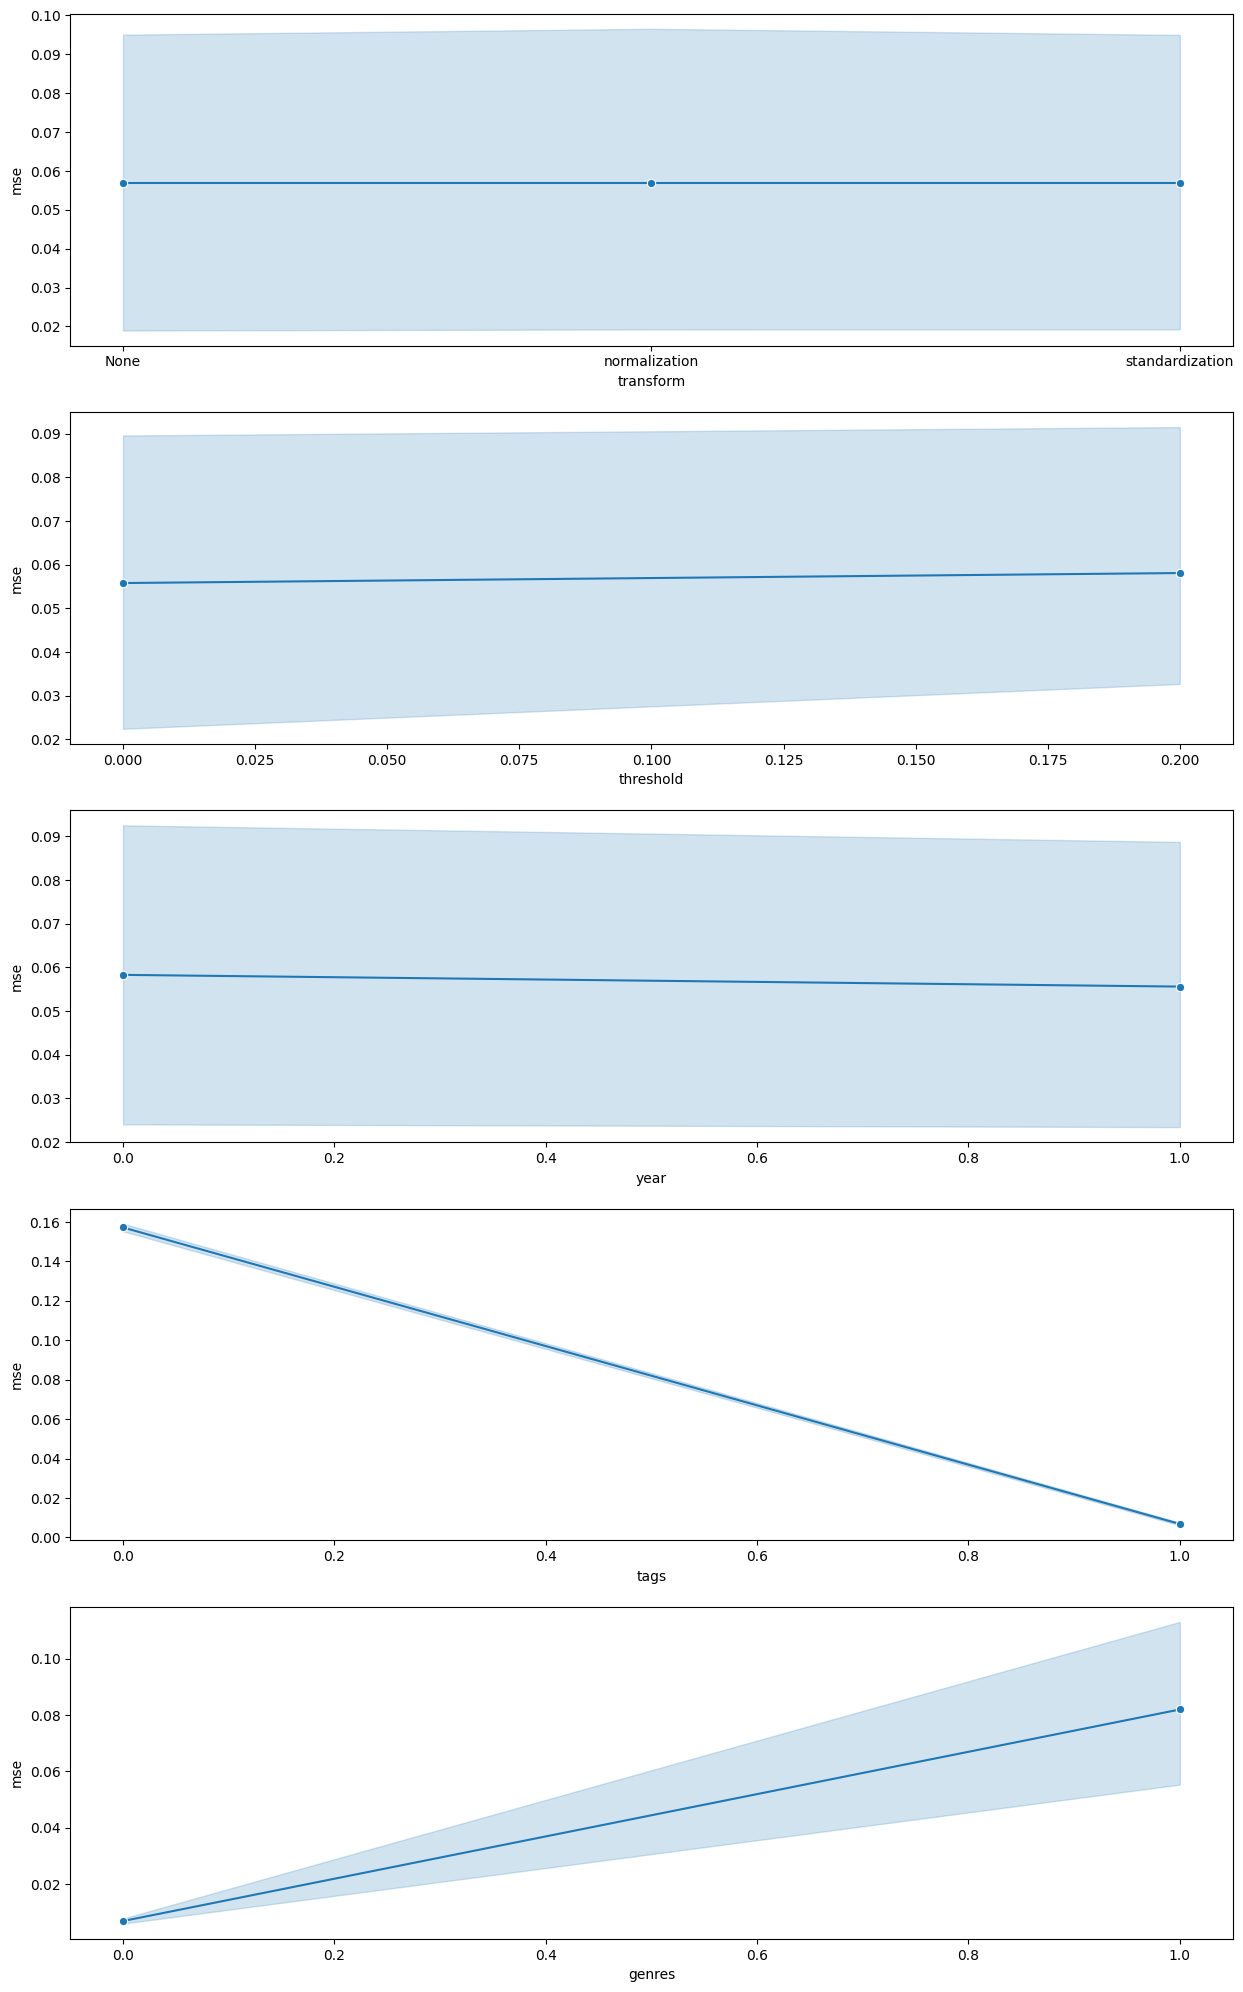

In [150]:
# plot over mse
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))
sns.lineplot(x='transform', y='mse', data=LR_datasets, ax=axs[0], marker='o')
sns.lineplot(x='threshold', y='mse', data=LR_datasets, ax=axs[1], marker='o')
sns.lineplot(x='year', y='mse', data=LR_datasets, ax=axs[2], marker='o')
sns.lineplot(x='tags', y='mse', data=LR_datasets, ax=axs[3], marker='o')
sns.lineplot(x='genres', y='mse', data=LR_datasets, ax=axs[4], marker='o')

plt.show()


#### SVM

In [303]:
""" # Create SVM model in sklearn

# Create the model
SVM_model = SVR(kernel='linear')

# Train the model on the training data
SVM_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = SVM_model.predict(X_test)
print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred))

"""


" # Create SVM model in sklearn\n\n# Create the model\nSVM_model = SVR(kernel='linear')\n\n# Train the model on the training data\nSVM_model.fit(X_train, y_train)\n\n# Evaluate the model on the test data\ny_pred = SVM_model.predict(X_test)\nprint('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))\nprint('Coefficient of determination: %.4f' % r2_score(y_test, y_pred))\n\n"

### KNN


n_neighbors = 1
Mean squared error: 0.2526
Coefficient of determination: -0.0976

n_neighbors = 2
Mean squared error: 0.1984
Coefficient of determination: 0.1380

n_neighbors = 3
Mean squared error: 0.1806
Coefficient of determination: 0.2152

n_neighbors = 4
Mean squared error: 0.1729
Coefficient of determination: 0.2486

n_neighbors = 5
Mean squared error: 0.1660
Coefficient of determination: 0.2789

n_neighbors = 6
Mean squared error: 0.1650
Coefficient of determination: 0.2829

n_neighbors = 7
Mean squared error: 0.1642
Coefficient of determination: 0.2865

n_neighbors = 8
Mean squared error: 0.1618
Coefficient of determination: 0.2970

n_neighbors = 9
Mean squared error: 0.1619
Coefficient of determination: 0.2964

n_neighbors = 10
Mean squared error: 0.1618
Coefficient of determination: 0.2969

n_neighbors = 11
Mean squared error: 0.1609
Coefficient of determination: 0.3011

n_neighbors = 12
Mean squared error: 0.1604
Coefficient of determination: 0.3032

n_neighbors = 13
Mean s

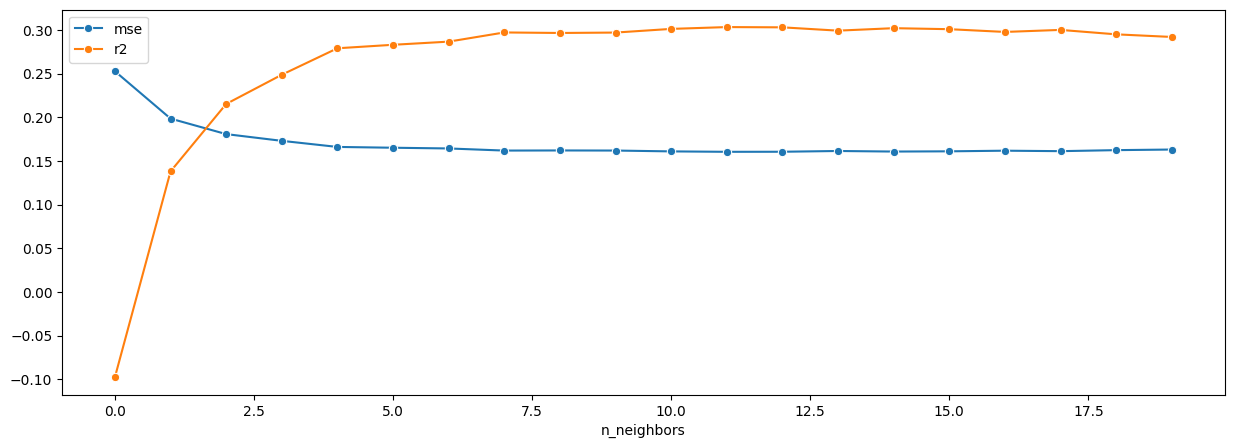

In [304]:
n_neighbors = list(range(1, 21))

mse = []
r2 = []
for n in n_neighbors:
    print('\nn_neighbors =', n)
    KNN_model = KNeighborsRegressor(n_neighbors=n)
    KNN_model.fit(X_train, y_train)

    # Evaluate the model on the test data
    y_pred = KNN_model.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))
    r2.append(r2_score(y_test, y_pred))
    print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
    print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred))

    """ display(y_test[:5])
    display(y_pred[:5]) """

# show in the same plot the accuracy, recall and precision for each hyperparameter combination

fig, ax = plt.subplots(figsize=(15,5))

ax1 = sns.lineplot(x=n_neighbors, y=mse, label='mse', marker='o')
ax1 = sns.lineplot(x=n_neighbors, y=r2, label='r2', marker='o')
#ax1.set_xticklabels([str(i) for i in range(len(n_neighbors))])
ax1.set_xlabel('n_neighbors')
plt.xticks(n_neighbors)
plt.grid(True)
plt.legend()
plt.show()


### Decision Trees

In [305]:
DT_model = DecisionTreeRegressor()
DT_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = DT_model.predict(X_test)
print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred))


Mean squared error: 0.2362
Coefficient of determination: -0.0262


### Modeling the problem as classification


n_trees = 10 	criterion = gini
Accuracy: 0.3696
Recall: 0.2016
Precision: 0.3061

n_trees = 10 	criterion = entropy
Accuracy: 0.3746
Recall: 0.2089
Precision: 0.2296

n_trees = 50 	criterion = gini
Accuracy: 0.3826
Recall: 0.2039
Precision: 0.3088

n_trees = 50 	criterion = entropy
Accuracy: 0.3848
Recall: 0.2105
Precision: 0.3635

n_trees = 100 	criterion = gini
Accuracy: 0.3877
Recall: 0.2100
Precision: 0.3126

n_trees = 100 	criterion = entropy
Accuracy: 0.3913
Recall: 0.2094
Precision: 0.3115


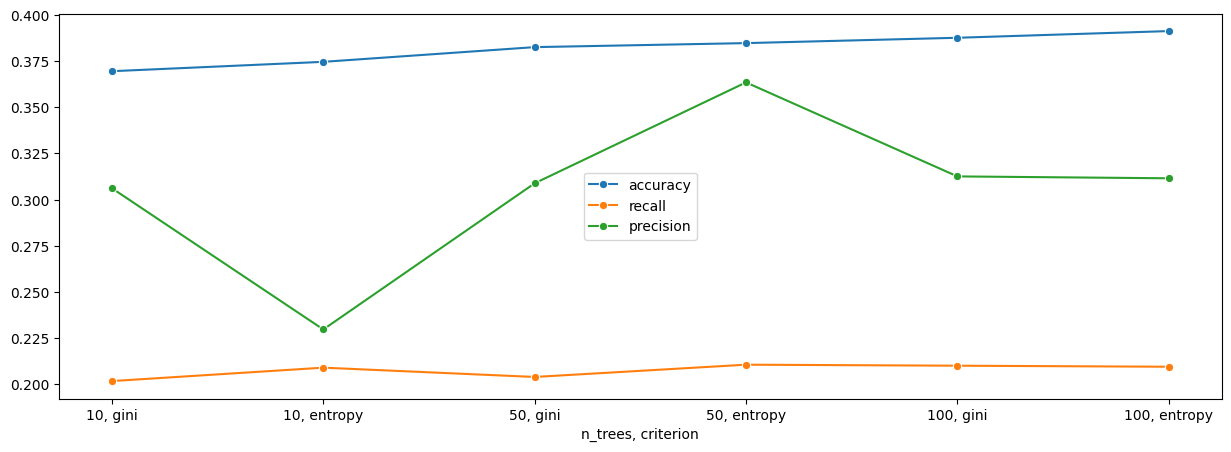

In [306]:
""" # bin y_train and y_test into 10 bins
y_train_binned = pd.cut(y_train, 10, labels=False)
y_test_binned = pd.cut(y_test, 10, labels=False)

# print('Binned values:', np.unique(y_train_binned))
# display(y_train_binned[:5])

# use the binned values to train the model

n_trees = [10, 50, 100]
criterion = ['gini', 'entropy']

hyperparameters = itertools.product(n_trees, criterion)

accuracy = []
recall = []
precision = []

for n, c in hyperparameters:
    print('\nn_trees =', n, '\tcriterion =', c)
    RFC_classifier = RandomForestClassifier(n_estimators=n, criterion=c)
    RFC_classifier.fit(X_train, y_train_binned)

    y_pred = RFC_classifier.predict(X_test)

    # evaluation of y_pred
    accuracy.append(accuracy_score(y_test_binned, y_pred))
    recall.append(recall_score(y_test_binned, y_pred, average='macro'))
    precision.append(precision_score(y_test_binned, y_pred, average='macro'))
    print('Accuracy: %.4f' % accuracy_score(y_test_binned, y_pred))
    print('Recall: %.4f' % recall_score(y_test_binned, y_pred, average='macro'))
    print('Precision: %.4f' % precision_score(y_test_binned, y_pred, average='macro'))

    # display(y_test_binned[:5])
    # display(y_pred[:5])


# show in the same plot the accuracy, recall and precision for each hyperparameter combination

fig, ax = plt.subplots(figsize=(15,5))

ax1 = sns.lineplot(accuracy, label='accuracy', marker='o')
ax1 = sns.lineplot(recall, label='recall', marker='o')
ax1 = sns.lineplot(precision, label='precision', marker='o')
ax1.set_xticklabels(['_','10, gini','10, entropy','50, gini','50, entropy','100, gini','100, entropy'])
ax1.set_xlabel('n_trees, criterion')

plt.legend()
plt.show()
 """


### NN

In [307]:
import pandas as pd
import numpy as np
import random
import itertools
import warnings
warnings.filterwarnings('ignore')
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn import decomposition

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset
from torch.utils.tensorboard import SummaryWriter


In [308]:
#look for GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print("Device: {}".format(device))


Device: mps


In [309]:
# reproducibility -> il risultato tra un run e il successivo è lo stesso
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)


In [310]:
# training process
def train_model(model, criterion, optimizer, epochs, data_loader, val_loader, device, writer):
    n_iter = 0
    patience = 10
    best_loss = np.inf
    best_model = None
    best_epoch = 0

    for epoch in range(epochs):
        model.train()
        # per verificare che ci troviamo in training e non in validation per evitare che il modello aggiorni i pesi
        for data, targets in data_loader:
            # per spostare il minibatch in GPU
            data, targets = data.to(device), targets.to(device)
            # Forward pass -> chiama la funzione forward
            y_pred = model(data)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), targets)
            # serve per azzerare il gradiente
            optimizer.zero_grad()
            # la barra separa Loss e la sezione train
            writer.add_scalar("Loss/train", loss, n_iter)
            # Backward pass
            loss.backward()
            # aggiorna i pesi della rete
            optimizer.step()
            n_iter += 1

        
        # validation
        loss_val, _, _ = test_model(model, criterion, val_loader, device)

        # early stopping
        if loss_val <= best_loss:
            best_loss = loss_val
            best_model = copy.deepcopy(model)
            best_epoch = epoch+1
            patience = 10
        else:
            patience = patience - 1
            if patience == 0:
                print("\nEarly stopping", end='')
                return best_model, best_epoch

        print("Epoch: [{}/{}],\tPatience: {},\tLoss: {:.4f},\tVal Loss: {:.4f}".format(epoch+1, epochs, patience, loss, loss_val), end='\r')
        writer.add_scalar("Loss/val", loss_val, epoch)
    
    return best_model, best_epoch



#evaluation process -> utilizzata sia per la validation che per il test
def test_model(model, criterion, data_loader, device):
    # model.eval() # per evitare che il modello aggiorni i pesi
    loss = 0
    y_pred = torch.tensor([]).to(device)
    y_true = torch.tensor([]).to(device)
    num_samples = 0
    
    for data, targets in data_loader:
        num_samples += 1
        data, targets = data.to(device), targets.to(device)
        try :
            output = model(data)
        except:
            continue
        loss += criterion(output.squeeze(), targets)
        y_pred = torch.cat((y_pred, output), 0)
        y_true = torch.cat((y_true, targets), 0)

    return loss/num_samples, y_pred.squeeze(), y_true

In [311]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_prob=0):
        super(NN, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.dp = dropout_prob
        
        model = [
            nn.Linear(self.input_size, self.hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(self.dp)
        ]
        
        for i in range(1, len(self.hidden_sizes)):
            model.append(nn.Linear(self.hidden_sizes[i-1], self.hidden_sizes[i]))
            model.append(nn.ReLU())
            model.append(nn.Dropout(self.dp))
        
        model.append(nn.Linear(self.hidden_sizes[-1], 1))
        
        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        return x.squeeze()


In [253]:
class RatingDataset(Dataset):
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test):
        
        self.num_features = X_train.shape[1]
        
        self.X_train = X_train.to_numpy()
        self.y_train = y_train.to_numpy()
        self.X_val = X_val.to_numpy()
        self.y_val = y_val.to_numpy()
        self.X_test = X_test.to_numpy()
        self.y_test = y_test.to_numpy()

        # PCA
        pca = decomposition.PCA(n_components=0.95)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_val = pca.transform(X_val)
        X_test = pca.transform(X_test)

        self.val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_val, dtype=torch.float32), torch.tensor(self.y_val, dtype=torch.float32)), batch_size=y_val.shape[0], shuffle=False)
        self.test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_test, dtype=torch.float32), torch.tensor(self.y_test, dtype=torch.float32)), batch_size=y_test.shape[0], shuffle=False)
    
    def get_train_loader(self, batch_size):
        return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_train, dtype=torch.float32), torch.tensor(self.y_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)
    
    def get_val_test_loaders(self, batch_size):
        val = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_val, dtype=torch.float32), torch.tensor(self.y_val, dtype=torch.float32)), batch_size=batch_size, shuffle=False)
        test = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_test, dtype=torch.float32), torch.tensor(self.y_test, dtype=torch.float32)), batch_size=batch_size, shuffle=False)
        return val, test

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]


In [254]:
device = torch.device("cpu")

#hyperparameters
hidden_sizes = [[512, 256, 512]]
nums_epochs = [200]
batch_sizes = [8]
learning_rate = [0.01]
dropout_prob = [0.0]
val_test_batch_sizes = [X_train.shape[0]]
momentum = [0.9]
scheduler_step_size = [10]
scheduler_gamma = [0.1]

# crea tutte le possibili combinazioni di iperparametri
hyperparameters = itertools.product(hidden_sizes, nums_epochs, batch_sizes, learning_rate, dropout_prob, val_test_batch_sizes, momentum, scheduler_step_size, scheduler_gamma)

# hp_list = list(hyperparameters)
# print how many combinations of hyperparameters
# print("Number of combinations: {}".format(len(hp_list)))

# data
my_dataset = RatingDataset(X_train, y_train, X_val, y_val, X_test, y_test)

my_table = pd.DataFrame(columns=['hidden_size', 'num_epochs', 'batch_size', 'learning_rate', 'dropout_prob', 'MSE', 'R2'])

#grid search loop
for i, [hidden_size, num_epochs, batch, learning_rate, dropout_prob, val_test_batch_size, momentum, scheduler_step_size, scheduler_gamma] in enumerate(hyperparameters):
    """ if hidden_size[0] > 64:
        device = torch.device("mps")
    else:
        device = torch.device("cpu") """
    if hidden_size == [512, 512, 512] and (batch > 4 or (batch == 4 and learning_rate == 0.1)):
        continue
        
    print('\nDevice: {}'.format(device))

    val_loader, test_loader = my_dataset.get_val_test_loaders(val_test_batch_size)
    print("iter: {}, hidden_size: {}, num_epochs: {}, batch_size: {}, learning_rate: {}, dropout_prob: {}, val_test_batch_size: {}, momentum: {}, scheduler_step_size: {}, scheduler_gamma: {}".format(i, hidden_size, num_epochs, batch, learning_rate, dropout_prob, val_test_batch_size, momentum, scheduler_step_size, scheduler_gamma))

    log_name = "dim:"+str(hidden_size)+"-ep:"+str(num_epochs)+"-bs:"+str(batch) + "-lr:"+str(learning_rate)

    #start tensorboard
    writer = SummaryWriter('runs/'+log_name)

    
    train_loader = my_dataset.get_train_loader(batch)

    #define architecture, loss and optimizer
    model = NN(my_dataset.num_features, hidden_size, dropout_prob)


    #train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)), batch_size=batch, shuffle=True)
    #model = get_model(X_train.shape[1], hidden_size, dropout_prob)
    
    criterion = torch.nn.MSELoss()

    #train and validate
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    model, n_epochs = train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device, writer)

    mse, y_t, y_p = test_model(model, criterion, test_loader, device)
    print("\nMSE: {}".format(mse))
    try:
        r2 = r2_score(y_t.cpu().detach().numpy(), y_p.cpu().detach().numpy())
    except:
        r2 = 0
    print("R2: {}".format(r2))

    try:
        my_table.loc[my_table.shape[0]] = [hidden_size, n_epochs, batch, learning_rate, dropout_prob, mse.item(), r2]
        writer.add_scalar('metrics/test mse', mse.item())
        if not os.path.exists('models'):
            os.makedirs('models')
        torch.save(model.state_dict(), 'models/'+log_name)
    except:
        my_table.loc[my_table.shape[0]] = [hidden_size, n_epochs, batch, learning_rate, dropout_prob, 0, 0]
        writer.add_scalar('metrics/test mse', 0)
    
    """ writer.add_hparams(
        {'lr': learning_rate, 'bsize': batch, 'dim': hidden_size, 'num_epochs': num_epochs},
        {'hparam/mse': mse.item(), 'hparam/r2': r2} """

    writer.flush()
    
writer.close()



Device: cpu
iter: 0, hidden_size: [512, 256, 512], num_epochs: 200, batch_size: 8, learning_rate: 0.01, dropout_prob: 0.0, val_test_batch_size: 11176, momentum: 0.9, scheduler_step_size: 10, scheduler_gamma: 0.1
Epoch: [24/200],	Patience: 1,	Loss: 0.1109,	Val Loss: 0.13718
Early stopping
MSE: 0.14501090347766876
R2: -0.462680540296285


In [255]:
# choose best model from my_table.csv based on MSE
best_model = my_table.loc[my_table['MSE'].idxmin()]
#print(best_model)

print('hidden_size: {}, num_epochs: {}, batch_size: {}, learning_rate: {}, dropout_prob: {}'.format(best_model['hidden_size'], best_model['num_epochs'], best_model['batch_size'], best_model['learning_rate'], best_model['dropout_prob']))

hidden_size = best_model['hidden_size']
dropout_prob = best_model['dropout_prob']

# load best model from models folder
model = NN(my_dataset.num_features, hidden_size, dropout_prob)

model.load_state_dict(torch.load('models/dim:'+str(best_model['hidden_size'])+'-ep:'+str(200)+'-bs:'+str(best_model['batch_size'])+'-lr:'+str(best_model['learning_rate'])))
model.eval()

# test best model
mse, y_t, y_p = test_model(model, criterion, test_loader, device)
print("\nMSE: {}".format(mse))
r2 = r2_score(y_t.cpu().detach().numpy(), y_p.cpu().detach().numpy())
print("R2: {}".format(r2))


hidden_size: [512, 256, 512], num_epochs: 15, batch_size: 8, learning_rate: 0.01, dropout_prob: 0.0

MSE: 0.14501090347766876
R2: -0.462680540296285


In [271]:
""" # test a specific model

hidden_size = [64, 64, 64]
batch_size = 16
learning_rate = 0.01
dropout_prob = 0.0

# load best model from models folder
model = NN(my_dataset.num_features, hidden_size, dropout_prob)

model.load_state_dict(torch.load('models/dim:'+str(hidden_size)+'-ep:'+str(200)+'-bs:'+str(batch_size)+'-lr:'+str(learning_rate)))
model.eval()

# test best model
mse, y_t, y_p = test_model(model, criterion, test_loader, device)
print("\nMSE: {}".format(mse))
r2 = r2_score(y_t.cpu().detach().numpy(), y_p.cpu().detach().numpy())
print("R2: {}".format(r2)) """


RuntimeError: Error(s) in loading state_dict for NN:
	size mismatch for model.0.weight: copying a param with shape torch.Size([64, 204]) from checkpoint, the shape in current model is torch.Size([64, 22]).

In [256]:
my_table = pd.read_csv('my_table.csv')

# remove from my_table all the rows with mse = 0 or r2 < 0
my_table = my_table[my_table['MSE'] > 0]
my_table = my_table[my_table['R2'] > 0]

# order my_table by batch_size, learning_rate, dropout_prob
my_table = my_table.sort_values(by=['batch_size', 'learning_rate'])

display(my_table.head(10))

my_table.to_csv('my_table3.csv', index=False)

my_table = pd.read_csv('my_table3.csv')

# convert my_table_hidden_size to list of tuples
my_table['hidden_size'] = my_table['hidden_size'].apply(lambda x: ast.literal_eval(x))

# order my_table by lambda x: ast.literal_eval(x)[0]
my_table = my_table.sort_values(by=['hidden_size'])

display(my_table.head(10))

my_table.to_csv('my_table4.csv', index=False)


,hidden_size,num_epochs,batch_size,learning_rate,dropout_prob,MSE,R2
0,"[16, 16, 16]",37,4,0.001,0.0,0.007129,0.967062
1,"[16, 16, 16]",24,4,0.001,0.1,0.021598,0.895255
2,"[16, 16, 16]",36,4,0.001,0.2,0.032403,0.844625
3,"[32, 32, 32]",25,4,0.001,0.0,0.007005,0.967284
4,"[32, 32, 32]",37,4,0.001,0.1,0.014057,0.935482
5,"[32, 32, 32]",50,4,0.001,0.2,0.015275,0.929868
6,"[64, 64, 64]",36,4,0.001,0.0,0.006565,0.970752
7,"[64, 64, 64]",39,4,0.001,0.1,0.009961,0.954563
8,"[64, 64, 64]",61,4,0.001,0.2,0.013283,0.939256
9,"[16, 8, 16]",56,4,0.001,0.0,0.006859,0.969506


,hidden_size,num_epochs,batch_size,learning_rate,dropout_prob,MSE,R2
380,"[16, 8, 16]",105,32,0.001,0.2,0.044949,0.755913
1051,"[16, 8, 16]",57,512,0.010,0.2,0.086679,0.378795
1050,"[16, 8, 16]",53,512,0.010,0.1,0.047170,0.742517
533,"[16, 8, 16]",46,64,0.001,0.2,0.067147,0.602389
532,"[16, 8, 16]",73,64,0.001,0.1,0.025955,0.870169
531,"[16, 8, 16]",198,64,0.001,0.0,0.007621,0.965585
895,"[16, 8, 16]",167,256,0.010,0.0,0.007747,0.964707
484,"[16, 8, 16]",14,32,0.100,0.1,0.056282,0.677570
483,"[16, 8, 16]",13,32,0.100,0.0,0.008648,0.960057
228,"[16, 8, 16]",70,16,0.001,0.0,0.007214,0.967156


In [270]:
# apply green color to first 10 min MSE
# my_table.style.applymap(lambda x: 'background-color: red' if x == my_table['MSE'].min() else '', subset=['MSE']).applymap(lambda x: 'background-color: green' if x < 0.0063 else '', subset=['MSE'])

# print first min MSE
my_table.sort_values(by=['MSE']).head(20)


,hidden_size,num_epochs,batch_size,learning_rate,dropout_prob,MSE,R2
198,"[512, 256, 512]",19,8,0.010,0.0,0.006122,0.972344
314,"[512, 256, 512]",25,16,0.010,0.0,0.006211,0.971761
661,"[256, 128, 256]",36,64,0.100,0.0,0.006229,0.972385
186,"[256, 256, 256]",21,8,0.010,0.0,0.006237,0.972629
189,"[512, 512, 512]",25,8,0.010,0.0,0.006253,0.971472
48,"[256, 512, 256]",39,4,0.001,0.0,0.006273,0.972275
772,"[512, 256, 512]",75,128,0.010,0.0,0.006287,0.971851
39,"[512, 256, 512]",38,4,0.001,0.0,0.006302,0.971982
781,"[256, 512, 256]",107,128,0.010,0.0,0.006335,0.971437
451,"[256, 256, 256]",40,32,0.010,0.0,0.006335,0.972073


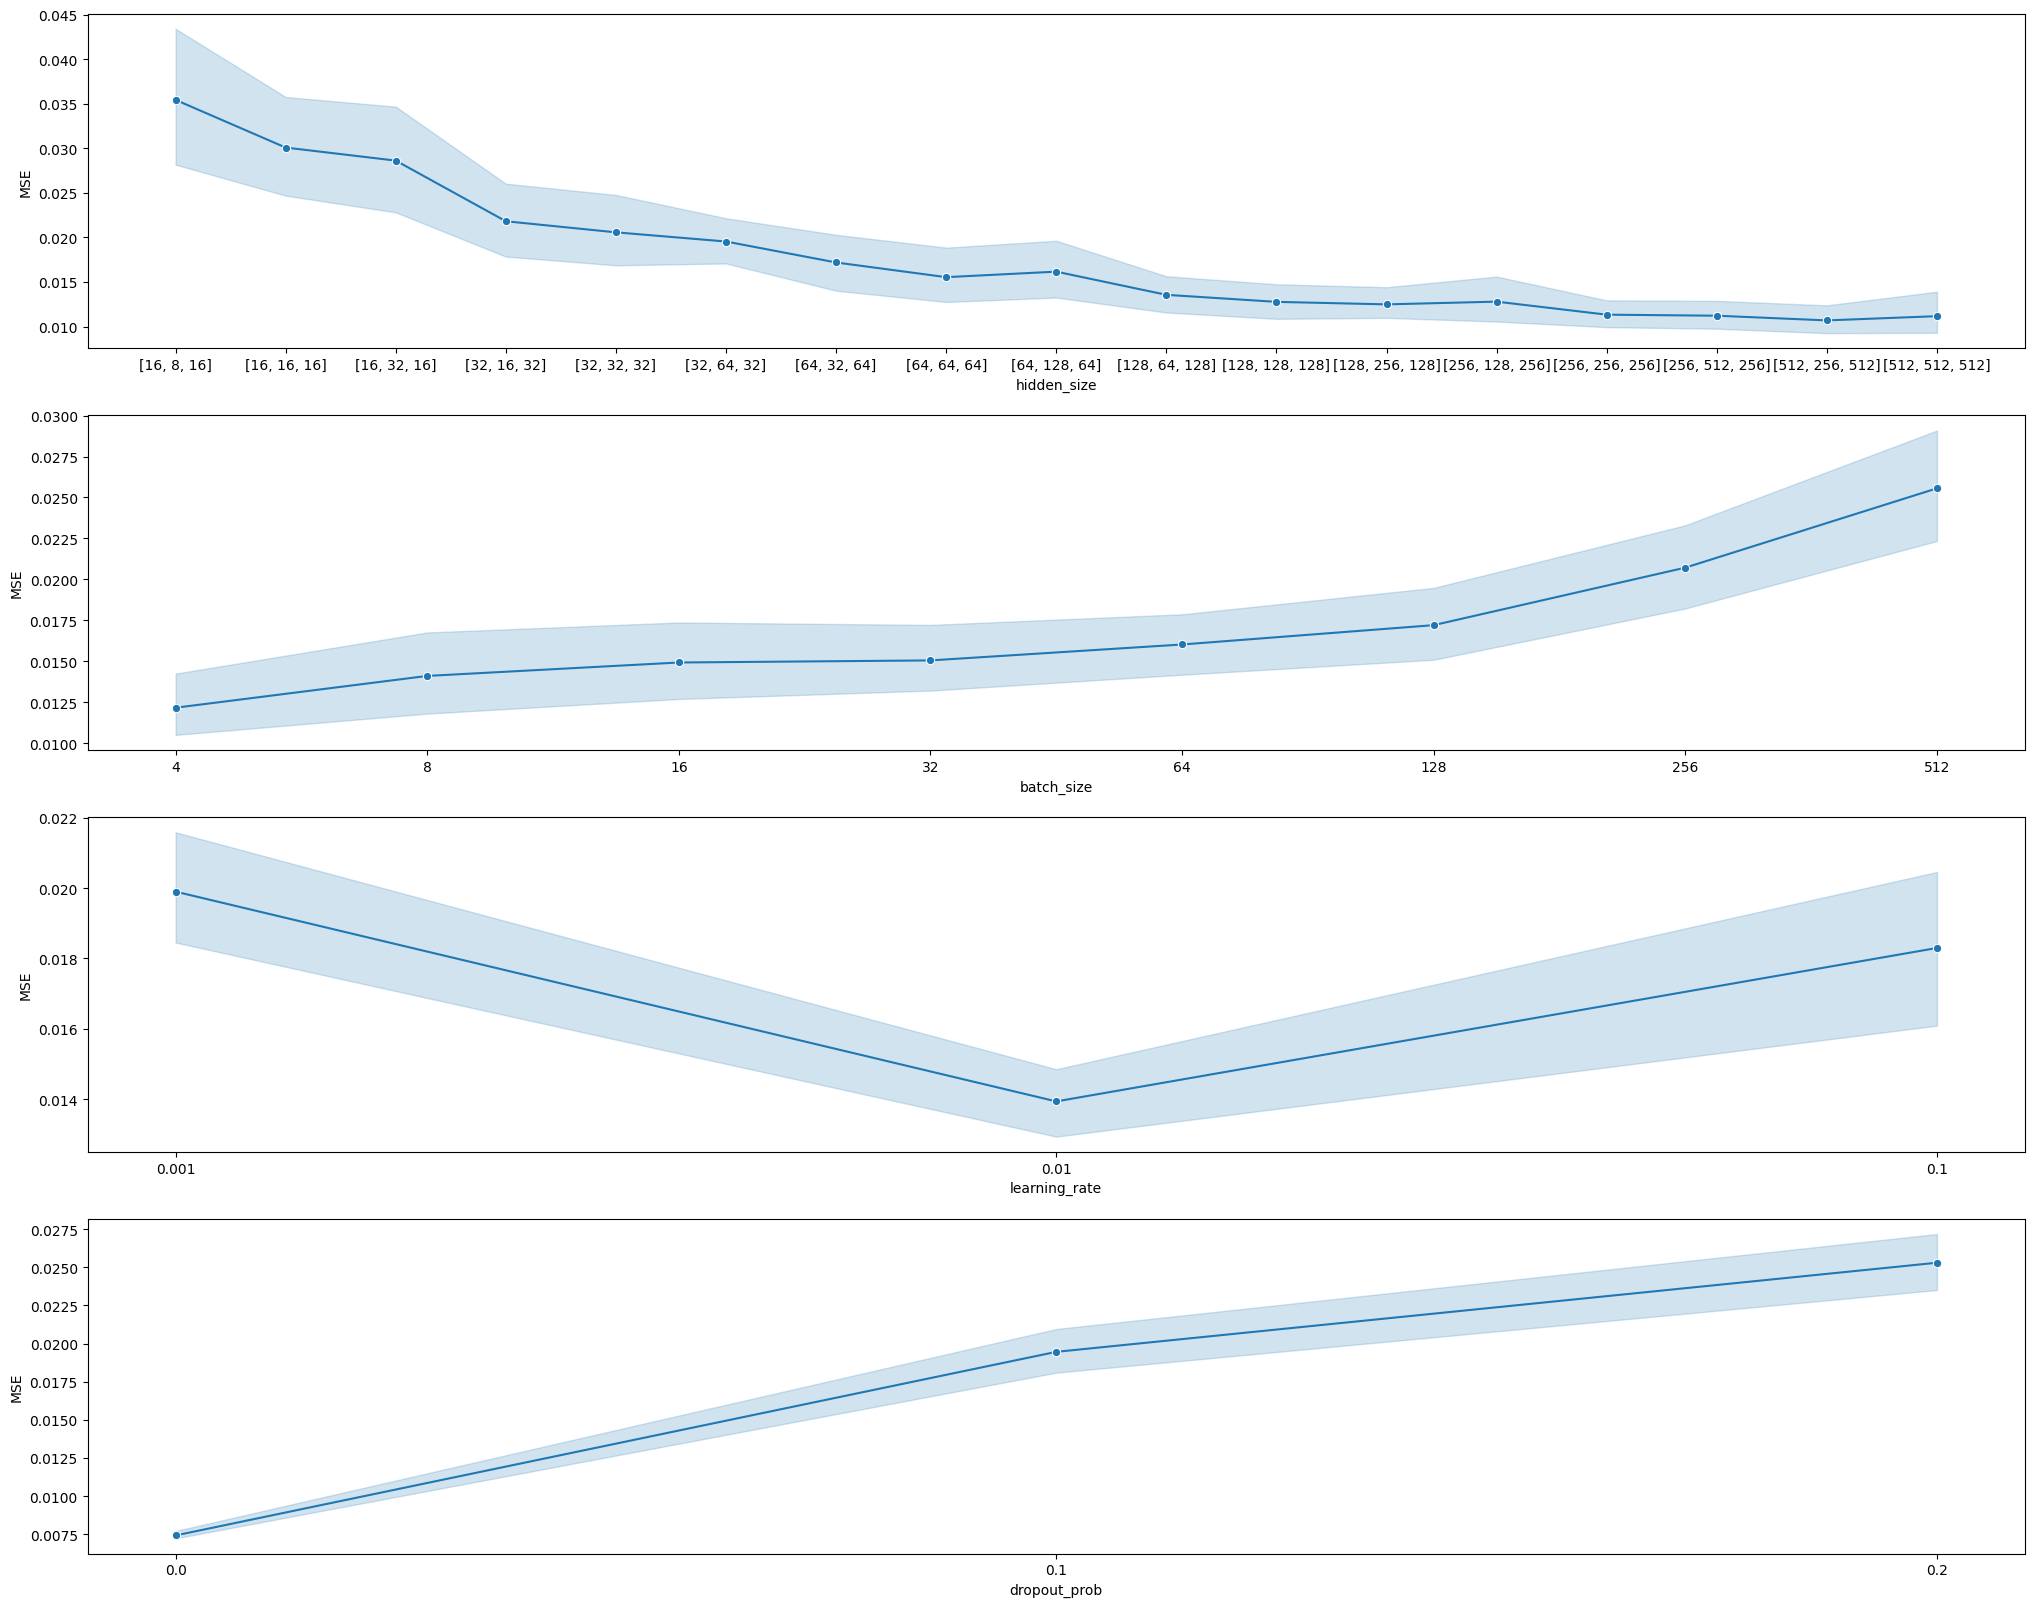

In [258]:
# plot x = [hidden_size, num_epochs, batch_size, learning_rate, dropout_prob], y = MSE

my_table = pd.read_csv('my_table4.csv')

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(25, 20))
sns.lineplot(x=my_table['hidden_size'].apply(lambda x: str(x)), y='MSE', data=my_table, ax=axs[0], marker='o')
my_table = pd.read_csv('my_table3.csv')
sns.lineplot(x=my_table['batch_size'].apply(lambda x: str(x)), y='MSE', data=my_table, ax=axs[1], marker='o')
sns.lineplot(x=my_table['learning_rate'].apply(lambda x: str(x)), y='MSE', data=my_table, ax=axs[2], marker='o')
sns.lineplot(x=my_table['dropout_prob'].apply(lambda x: str(x)), y='MSE', data=my_table, ax=axs[3], marker='o')

plt.show()


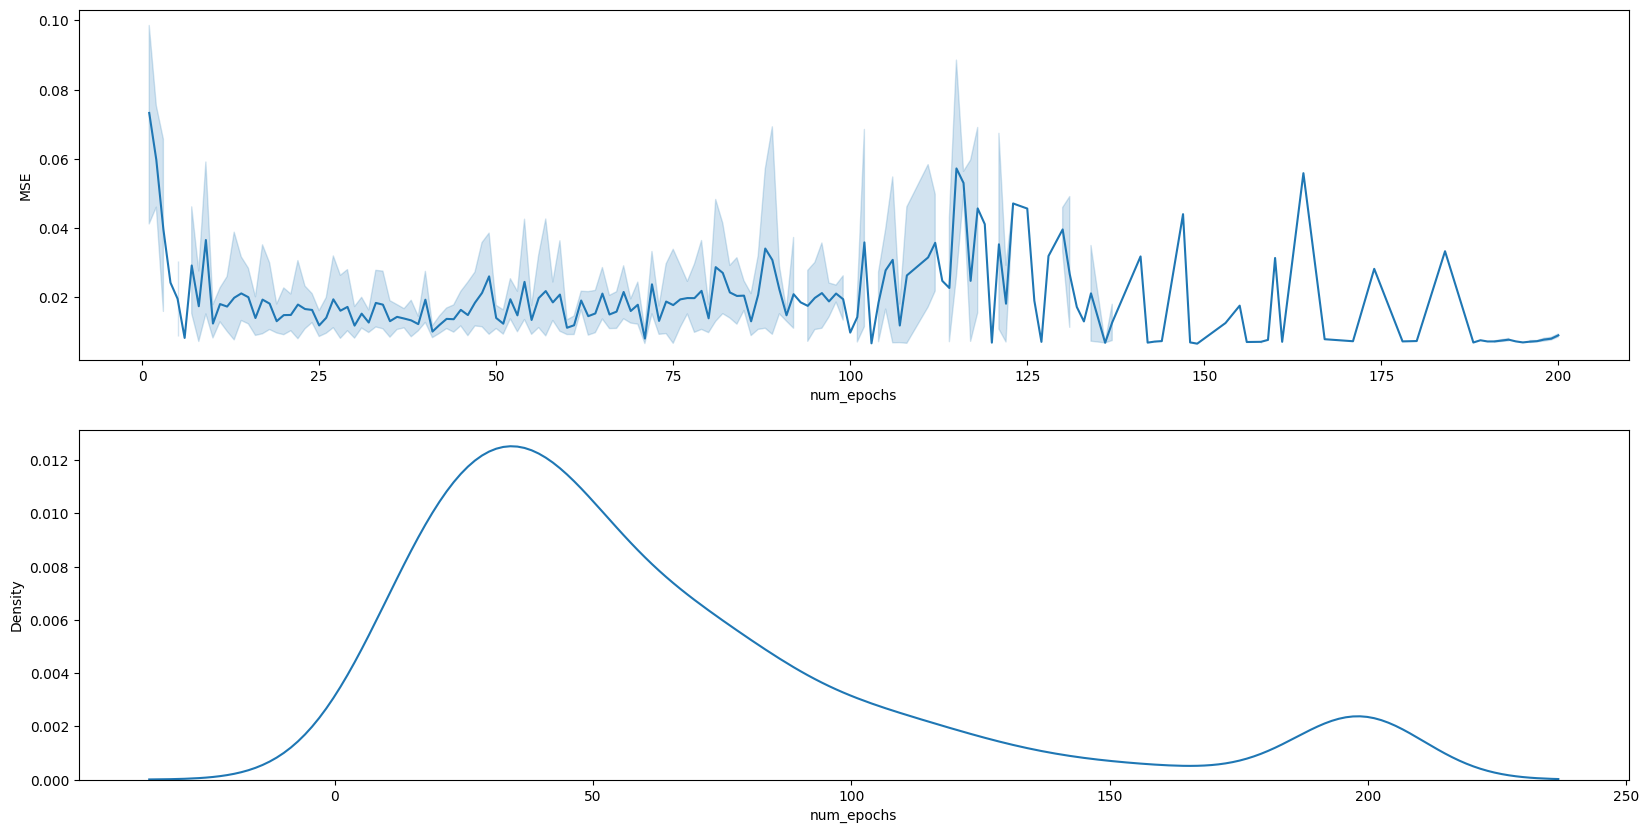

In [259]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sns.lineplot(x=my_table['num_epochs'], y='MSE', data=my_table, ax=axs[0])
sns.kdeplot(my_table['num_epochs'], ax=axs[1])

plt.show()

### Tabular 1

In [260]:
train_tabular, test_tabular = train_test_split(df, random_state=42, test_size=0.1)
train_tabular, val_tabular = train_test_split(train_tabular, random_state=42, test_size=0.1)

label = ['mean_rating']

categorical_columns = ['IMAX', 'Film-Noir']

# continuous_columns is all_columns - [label, categorical_columns]
continuous_columns = list(df.columns)
continuous_columns.remove('mean_rating')
continuous_columns.remove('IMAX')
continuous_columns.remove('Film-Noir')
# continuous_columns = list(df.columns).remove(label).remove(categorical_columns)


In [261]:
batch_size = 1024
steps_per_epoch = int(train_tabular.shape[0]/1024)
epochs = 200

data_config = DataConfig(
    target=label,
    continuous_cols=continuous_columns,
    categorical_cols=categorical_columns,
    # date_columns=[],
    # encode_date_columns=True,
    validation_split=0.1,
    # continuous_feature_transform=["yeo-johnson", "box-cox", "quantile_normal", "quantile_uniform", "yeo-johnson", "box-cox", "quantile_normal", "quantile_uniform"],
    normalize_continuous_features=True,
)

optimizer_config = OptimizerConfig(lr_scheduler="OneCycleLR", lr_scheduler_params={"max_lr":0.00478, "epochs": epochs, "steps_per_epoch":steps_per_epoch})

head_config = LinearHeadConfig(
    layers="", 
    dropout=0.1,
    initialization="kaiming"
).__dict__ 

model_config = CategoryEmbeddingModelConfig(
    task="regression",
    layers="1024-512-512",
    activation="LeakyReLU",
    dropout=0.1,
    initialization="kaiming",
    head = "LinearHead",
    head_config = head_config,
    learning_rate = 1e-3
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config="trainer_config.yaml",
)


2023-03-20 14:03:50,749 - {pytorch_tabular.tabular_model:102} - INFO - Experiment Tracking is turned off


In [262]:
datamodule = tabular_model.prepare_dataloader(
                train=train_tabular, validation=val_tabular, seed=42
            )
model = tabular_model.prepare_model(
            datamodule
        )
tabular_model.train(model, datamodule)


result = tabular_model.evaluate(test_tabular)


tabular_model.save_model("examples/basic")


loaded_model = TabularModel.load_from_checkpoint("examples/basic")

pred_df = loaded_model.predict(test_tabular)
pred_df.head()

2023-03-20 14:03:50,798 - {pytorch_tabular.tabular_model:465} - INFO - Preparing the DataLoaders
2023-03-20 14:03:50,800 - {pytorch_tabular.tabular_datamodule:286} - INFO - Setting up the datamodule for regression task
2023-03-20 14:03:50,865 - {pytorch_tabular.tabular_model:508} - INFO - Preparing the Model: CategoryEmbeddingModel
2023-03-20 14:03:50,913 - {pytorch_tabular.tabular_model:264} - INFO - Preparing the Trainer


TypeError: `devices` selected with `CPUAccelerator` should be an int > 0.

### Tabular 2

In [ ]:
from typing import Any, Dict

import numpy as np
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero

device = torch.device('cpu')
# Docs: https://yura52.github.io/delu/0.0.4/reference/api/zero.improve_reproducibility.html
#zero.improve_reproducibility(seed=123456)



# !!! NOTE !!! The dataset splits, preprocessing and other details are
# significantly different from those used in the
# paper "Revisiting Deep Learning Models for Tabular Data",
# so the results will be different from the reported in the paper.

""" dataset = sklearn.datasets.fetch_california_housing() """
task_type = 'regression'

# dataset = sklearn.datasets.fetch_covtype()
# task_type = 'multiclass'

assert task_type in ['binclass', 'multiclass', 'regression']

""" X_all = dataset['data'].astype('float32')
y_all = dataset['target'].astype('float32' if task_type == 'regression' else 'int64') """

X_all = df.drop('mean_rating', axis=1).values.astype('float32')
y_all = df['mean_rating'].values.astype('float32' if task_type == 'regression' else 'int64')

if task_type != 'regression':
    y_all = sklearn.preprocessing.LabelEncoder().fit_transform(y_all).astype('int64')
n_classes = int(max(y_all)) + 1 if task_type == 'multiclass' else None

X = {}
y = {}
""" X['train'], X['test'], y['train'], y['test'] = sklearn.model_selection.train_test_split(
    X_all, y_all, train_size=0.8
)
X['train'], X['val'], y['train'], y['val'] = sklearn.model_selection.train_test_split(
    X['train'], y['train'], train_size=0.8
) """

X['train'], X['test'], X['val'], y['train'], y['test'], y['val'] = X_train, X_test, X_val, y_train, y_test, y_val

# not the best way to preprocess features, but enough for the demonstration
preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'])
X = {
    k: torch.tensor(preprocess.transform(v), device=device)
    for k, v in X.items()
}
y = {k: torch.tensor(v, device=device) for k, v in y.items()}

# !!! CRUCIAL for neural networks when solving regression problems !!!
if task_type == 'regression':
    y_mean = y['train'].mean().item()
    y_std = y['train'].std().item()
    y = {k: (v - y_mean) / y_std for k, v in y.items()}
else:
    y_std = y_mean = None

if task_type != 'multiclass':
    y = {k: v.float() for k, v in y.items()}






d_out = n_classes or 1

# model = rtdl.MLP.make_baseline(
#     d_in=X_all.shape[1],
#     d_layers=[128, 256, 128],
#     dropout=0.1,
#     d_out=d_out,
# )
# lr = 0.001
# weight_decay = 0.0

# model = rtdl.ResNet.make_baseline(
#     d_in=X_all.shape[1],
#     d_main=128,
#     d_intermidiate=256,
#     dropout_first=0.2,
#     dropout_second=0.0,
#     n_blocks=2,
#     d_out=d_out,
# )
# lr = 0.001
# weight_decay = 0.0

model = rtdl.FTTransformer.make_default(
    n_num_features=X_all.shape[1],
    cat_cardinalities=None,
    last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
    d_out=d_out,
)

# === ABOUT CATEGORICAL FEATURES ===
# IF you use MLP, ResNet or any other simple feed-forward model (NOT transformer-based model)
# AND there are categorical features
# THEN you have to implement a wrapper that handles categorical features.
# The example below demonstrates how it can be achieved using rtdl.CategoricalFeatureTokenizer.
# ==================================
# 1. When you have both numerical and categorical features, you should prepare you data like this:
#    (X_num<float32>, X_cat<int64>) instead of X<float32>
#    Each column in X_cat should contain values within the range from 0 to <(the number of unique values in column) - 1>;
#    use sklean.preprocessing.OrdinalEncoder to achieve this;
# 2. Prepare a list of so called "cardinalities":
#    cardinalities[i] = <the number of unique values of the i-th categorical feature>
# 3. See the commented example below and adapt it for your needs.
#
# class Model(nn.Module):
#     def __init__(
#         self,
#         n_num_features: int,
#         cat_tokenizer: rtdl.CategoricalFeatureTokenizer,
#         mlp_kwargs: Dict[str, Any],
#     ):
#         super().__init__()
#         self.cat_tokenizer = cat_tokenizer
#         self.model = rtdl.MLP.make_baseline(
#             d_in=n_num_features + cat_tokenizer.n_tokens * cat_tokenizer.d_token,
#             **mlp_kwargs,
#         )
#
#     def forward(self, x_num, x_cat):
#         return self.model(
#             torch.cat([x_num, self.cat_tokenizer(x_cat).flatten(1, -1)], dim=1)
#         )
#
# model = Model(
#     # `None` means "Do not transform numerical features"
#     # `d_token` is the size of embedding for ONE categorical feature
#     X_num_all.shape[1],
#     rtdl.CategoricalFeatureTokenizer(cardinalities, d_token, True, 'uniform'),
#     mlp_kwargs,
# )
# Then the model should be used as `model(x_num, x_cat)` instead of of `model(x)`.

lr = 0.001
weight_decay = 0.0

model.to(device)
optimizer = (
    model.make_default_optimizer()
    if isinstance(model, rtdl.FTTransformer)
    else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
)
loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == 'binclass'
    else F.cross_entropy
    if task_type == 'multiclass'
    else F.mse_loss
)




def apply_model(x_num, x_cat=None):
    if isinstance(model, rtdl.FTTransformer):
        return model(x_num, x_cat)
    elif isinstance(model, (rtdl.MLP, rtdl.ResNet)):
        assert x_cat is None
        return model(x_num)
    else:
        raise NotImplementedError(
            f'Looks like you are using a custom model: {type(model)}.'
            ' Then you have to implement this branch first.'
        )


@torch.no_grad()
def evaluate(part):
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], 1024):
        prediction.append(apply_model(batch))
    prediction = torch.cat(prediction).squeeze(1).cpu().numpy()
    target = y[part].cpu().numpy()

    if task_type == 'binclass':
        prediction = np.round(scipy.special.expit(prediction))
        score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
        prediction = prediction.argmax(1)
        score = sklearn.metrics.accuracy_score(target, prediction)
    else:
        assert task_type == 'regression'
        score = sklearn.metrics.mean_squared_error(target, prediction) ** 0.5 * y_std
    return score


# Create a dataloader for batches of indices
# Docs: https://yura52.github.io/delu/reference/api/zero.data.IndexLoader.html
batch_size = 256
train_loader = zero.data.IndexLoader(len(X['train']), batch_size, device=device)

# Create a progress tracker for early stopping
# Docs: https://yura52.github.io/delu/reference/api/zero.ProgressTracker.html
progress = zero.ProgressTracker(patience=100)

print(f'Test score before training: {evaluate("test"):.4f}')





n_epochs = 1000
report_frequency = len(X['train']) // batch_size // 5
for epoch in range(1, n_epochs + 1):
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = X['train'][batch_idx]
        y_batch = y['train'][batch_idx]
        loss = loss_fn(apply_model(x_batch).squeeze(1), y_batch)
        loss.backward()
        optimizer.step()
        if iteration % report_frequency == 0:
            print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

    val_score = evaluate('val')
    test_score = evaluate('test')
    print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f} | Test score: {test_score:.4f}', end='')
    progress.update((-1 if task_type == 'regression' else 1) * val_score)
    if progress.success:
        print(' <<< BEST VALIDATION EPOCH', end='')
    print()
    if progress.fail:
        break

KeyError: 3